In [1]:
import os
from pandas import read_csv
import pandas as pd
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from matplotlib import pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline
from scipy.sparse import hstack
import warnings
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, balanced_accuracy_score
warnings.filterwarnings("ignore")

## Data Preparation

In [3]:
final_path = '/Users/subashkhanal/Desktop/BMI633/ADNI_Genetics/Genomics/data/'
df = pd.read_csv(os.path.join(final_path,'Unfiltered_gene_expr_dx.csv'),low_memory=False)
from collections import Counter

print(Counter(df['DX_bl']))

df_CN = df[df['DX_bl']=='CN']
df_AD = df[df['DX_bl']=='AD']
df_EMCI = df[df['DX_bl']=='EMCI']
df_LMCI = df[df['DX_bl']=='LMCI']
df_AD2 =  df[(df['DX_bl']=='LMCI') | (df['DX_bl']=='AD')] #Combine AD with LMCI
df_AD2['DX_bl'] = 'AD2'
Counter(df_AD2.DX_bl)

Counter({'CN': 260, 'LMCI': 225, 'EMCI': 215, 'AD': 43, nan: 1})


Counter({'AD2': 268})

# t-test as Feature selection 

In [55]:
from scipy import stats
df_CN_exp = df_CN.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_AD_exp = df_AD.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_EMCI_exp = df_EMCI.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_LMCI_exp = df_LMCI.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')
df_AD2_exp = df_AD2.loc[:,'11715100_at_HIST1H3G': 'AFFX-r2-TagQ-5_at_nan'].astype('float')

p = []
data = df_CN_exp
from scipy import stats
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for CN group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution


p = []
data = df_EMCI_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for EMCI group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

p = []
data = df_LMCI_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for LMCI group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

p = []
data = df_AD_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for AD group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

p = []
data = df_AD2_exp
for col in data.columns:
    p.append(stats.normaltest(data[col])[1])
    
print("Average P value for normality test for all features for AD2 group is:",sum(p)/len(p))
# null hypothesis: x comes from a normal distribution

from scipy.stats import ttest_ind
import statsmodels.stats.multitest as multi

fdr_alpha =0.10 ##DEFAULT IS 0.05
alpha = fdr_alpha
gene_probes = df_AD_exp.columns
groups = ['CN_AD','CN_AD_c','CN_AD2','CN_AD2_c','CN_EMCI','CN_EMCI_c','CN_LMCI','CN_LMCI_c', 'EMCI_LMCI','EMCI_LMCI_c','EMCI_AD','EMCI_AD_c','LMCI_AD','LMCI_AD_c']
df_p = pd.DataFrame(columns=groups, index = gene_probes) #dataframe for collecting p values for test

for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_AD'],alpha = fdr_alpha) #FDR correction 
df_p['CN_AD_c'] = corr_p 
       

for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_AD2_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_AD2'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_AD'],alpha = fdr_alpha) #FDR correction 
df_p['CN_AD2_c'] = corr_p 


for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_AD'],alpha = fdr_alpha) #FDR correction 
df_p['CN_AD_c'] = corr_p 
       
for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_EMCI_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_EMCI'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_EMCI'],alpha = fdr_alpha) #FDR correction
df_p['CN_EMCI_c'] = corr_p 

for gene in gene_probes:
    data1 = df_CN_exp[gene]
    data2 = df_LMCI_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'CN_LMCI'] = p
hyp, corr_p = multi.fdrcorrection(df_p['CN_LMCI'],alpha = fdr_alpha) #FDR correction
df_p['CN_LMCI_c'] = corr_p 

for gene in gene_probes:
    data1 = df_EMCI_exp[gene]
    data2 = df_LMCI_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'EMCI_LMCI'] = p
hyp, corr_p = multi.fdrcorrection(df_p['EMCI_LMCI'],alpha = fdr_alpha) #FDR correction 
df_p['EMCI_LMCI_c'] = corr_p 
       
for gene in gene_probes:
    data1 = df_EMCI_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'EMCI_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['EMCI_AD'],alpha = fdr_alpha) #FDR correction
df_p['EMCI_AD_c'] = corr_p 

for gene in gene_probes:
    data1 = df_LMCI_exp[gene]
    data2 = df_AD_exp[gene]
    stat, p = ttest_ind(data1, data2)
    df_p.loc[gene,'LMCI_AD'] = p
hyp, corr_p = multi.fdrcorrection(df_p['LMCI_AD'],alpha = fdr_alpha) #FDR correction
df_p['LMCI_AD_c'] = corr_p 

df_p1 = df_p.reset_index()
df_p2 = df_p1.rename(columns={'index':'Gene'})
df_p2.to_csv(os.path.join(final_path,'t_test_0.10_geneExpr_Unfiltered_bl.csv'))
print("Ttest calculated for all the unfiltered probes among all baseline diagnostic groups in Gene Expression data")

Average P value for normality test for all features for CN group is: 0.15471668443855968
Average P value for normality test for all features for EMCI group is: 0.18720201363835318
Average P value for normality test for all features for LMCI group is: 0.16997089791068903
Average P value for normality test for all features for AD group is: 0.39529632415664845
Average P value for normality test for all features for AD2 group is: 0.1519048757424573
Ttest calculated for all the unfiltered probes among all baseline diagnostic groups in Gene Expression data


In [64]:
df_p2

,Gene,CN_AD,CN_AD_c,CN_AD2,CN_AD2_c,CN_EMCI,CN_EMCI_c,CN_LMCI,CN_LMCI_c,EMCI_LMCI,EMCI_LMCI_c,EMCI_AD,EMCI_AD_c,LMCI_AD,LMCI_AD_c
0,11715100_at_HIST1H3G,0.119932,0.525434,0.229526,0.525434,0.118086,0.999758,0.410742,0.866781,0.479903,0.763006,0.425398,0.853756,0.262941,0.570520
1,11715101_s_at_HIST1H3G,0.083275,0.475489,0.734551,0.475489,0.115153,0.999758,0.808447,0.968528,0.063339,0.354575,0.404734,0.849369,0.038940,0.267210
2,11715102_x_at_HIST1H3G,0.458232,0.795915,0.247435,0.795915,0.983860,0.999758,0.120523,0.716226,0.118698,0.444708,0.397229,0.845283,0.121134,0.410445
3,11715103_x_at_TNFAIP8L1,0.050121,0.412989,0.925775,0.412989,0.223114,0.999758,0.443920,0.876075,0.060844,0.350624,0.208603,0.743144,0.023196,0.224008
4,11715104_s_at_OTOP2,0.063475,0.441047,0.257047,0.441047,0.302293,0.999758,0.513945,0.897736,0.711742,0.884040,0.217173,0.749480,0.147077,0.444470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49381,AFFX-r2-TagJ-5_at_nan,0.508000,0.821214,0.708702,0.821214,0.314675,0.999758,0.852120,0.978105,0.220358,0.561943,0.195760,0.735610,0.540144,0.781705
49382,AFFX-r2-TagO-3_at_nan,0.045265,0.402342,0.003806,0.402342,0.094578,0.999758,0.009682,0.553781,0.401539,0.711273,0.333865,0.816590,0.637583,0.839447
49383,AFFX-r2-TagO-5_at_nan,0.087562,0.481377,0.132323,0.481377,0.610432,0.999758,0.262554,0.813033,0.566839,0.813185,0.160156,0.708409,0.265388,0.572608
49384,AFFX-r2-TagQ-3_at_nan,0.729931,0.915398,0.141109,0.915398,0.568927,0.999758,0.073976,0.675591,0.285345,0.622001,0.543609,0.897114,0.197716,0.505344


In [27]:
overall_groups = ['CN_AD','CN_EMCI','CN_LMCI','EMCI_LMCI','EMCI_AD','LMCI_AD']

## Classifier

In [91]:
N = 1500
data_path = final_path
groups = 'CN_AD'
classes = groups.split('_')
#Gene ranking based on ttest
ttest = read_csv(os.path.join(data_path,'t_test_0.10_geneExpr_Unfiltered_bl.csv')).sort_values(groups).reset_index()
important_probes = ttest.sort_values(groups+'_c')['Gene'][0:N] #suffix _c to use the FDR corrected p values 
#CHANGE THE LINE ABOVE ACCORDINGLY FOR DIFFERENT CLASSES

#Gene Expression Data
data_path = '/Users/subashkhanal/Desktop/BMI633/ADNI_Genetics/Genomics/data/'
df = pd.read_csv(os.path.join(data_path,'Unfiltered_gene_expr_dx.csv'),low_memory=False)
Gene_expr = df[['Unnamed: 0','AGE','PTGENDER','PTEDUCAT','DX_bl']+list(important_probes)]
df = Gene_expr
df_CN = df[df['DX_bl']=='CN']
df_AD = df[df['DX_bl']=='AD']
df_EMCI = df[df['DX_bl']=='EMCI']
df_LMCI = df[df['DX_bl']=='LMCI']
df_AD2 =  df[(df['DX_bl']=='LMCI') | (df['DX_bl']=='AD')] #Combine AD with LMCI
df_AD2['DX_bl'] = 'AD2'

curr_df = pd.concat([df_CN, df_AD], ignore_index=True) #CHANGE THIS LINE ACCORDINGLY FOR DIFFERENT CLASSES
curr_df['PTGENDER'] = curr_df['PTGENDER'].astype('category').cat.codes 
curr_df

,Unnamed: 0,AGE,PTGENDER,PTEDUCAT,DX_bl,11761978_at_ARHGEF12,11754382_a_at_SMIM5,11755705_a_at_SMIM5,11758611_s_at_TRIM10,11724079_s_at_E2F2,...,11757994_s_at_ZNF674,11717799_at_ZER1,11745264_a_at_RAD23B,11720759_s_at_IVNS1ABP,11754529_x_at_SLC3A2,11720395_a_at_NBN,11733071_a_at_SLC3A2,11720585_a_at_SMCHD1,11742314_x_at_SLC35G6,11743642_s_at_TFAP2A
0,116_S_1249,70.8,0,15.0,CN,4.573,7.203,7.587,7.559,9.251,...,5.208,7.756,5.480,8.903,8.052,8.082,6.989,8.197,2.584,2.471
1,037_S_4410,69.1,0,14.0,CN,4.969,5.378,5.535,5.297,8.335,...,5.485,6.425,5.670,8.655,7.776,8.114,6.726,7.876,2.608,2.129
2,116_S_1232,72.1,0,14.0,CN,6.287,8.110,8.376,9.000,10.421,...,4.640,8.138,5.651,8.235,8.343,8.122,7.380,7.632,2.915,2.316
3,036_S_4491,84.1,1,19.0,CN,5.102,7.619,7.938,7.256,9.904,...,4.505,8.871,5.542,7.134,8.643,7.633,7.763,7.475,3.310,2.420
4,037_S_4308,74.0,1,16.0,CN,4.270,5.541,5.888,6.708,8.958,...,4.850,6.854,5.833,8.901,7.767,8.110,6.781,7.808,2.808,2.204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,031_S_4024,55.9,0,16.0,AD,4.319,5.740,6.052,5.134,8.456,...,4.802,7.082,5.519,8.607,8.186,8.185,7.168,8.033,3.072,2.175
299,137_S_4258,75.8,1,14.0,AD,4.283,5.856,5.952,4.941,8.740,...,5.185,6.903,5.483,8.370,8.074,8.349,6.997,7.582,2.618,2.028
300,098_S_4201,64.0,0,15.0,AD,5.301,7.151,7.608,7.651,9.136,...,4.915,7.736,5.895,8.408,8.060,7.914,7.330,8.290,2.247,2.342
301,014_S_4039,55.9,1,19.0,AD,3.586,6.409,6.699,5.941,8.514,...,5.342,7.507,5.654,8.718,7.734,8.261,6.834,8.002,2.876,2.372


In [92]:
Counter(df.DX_bl)

Counter({'CN': 260, 'AD': 43, 'EMCI': 215, 'LMCI': 225, nan: 1})

In [93]:
Counter(curr_df.DX_bl)

Counter({'CN': 260, 'AD': 43})

In [94]:
curr_df.columns[curr_df.isna().any()].tolist()

[]

In [95]:
from sklearn.preprocessing import LabelBinarizer

def prepare_targets(y):
    le = LabelEncoder()
    le.fit(y)
    y = le.transform(y)
    return y

#Very inefficient approach! but is easier to visualize in my head
def data_prep(df): #This takes the dataframe and returns the one hot encoded expansion of input features
    target = prepare_targets(list(df.DX_bl))
    df1 = df.drop(columns=['Unnamed: 0','DX_bl']).reset_index(drop=True) #Patient ID and DIAG not needed  
    return df1, target
df, y = data_prep(curr_df)
print(df.shape, y.shape)

(303, 1503) (303,)


## Hyperparameters Grid Search

Adapted from https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/

Best Score: 0.5912393162393161
Best Hyperparameters: {'n_estimators': 3000}
Automatically created module for IPython interactive environment


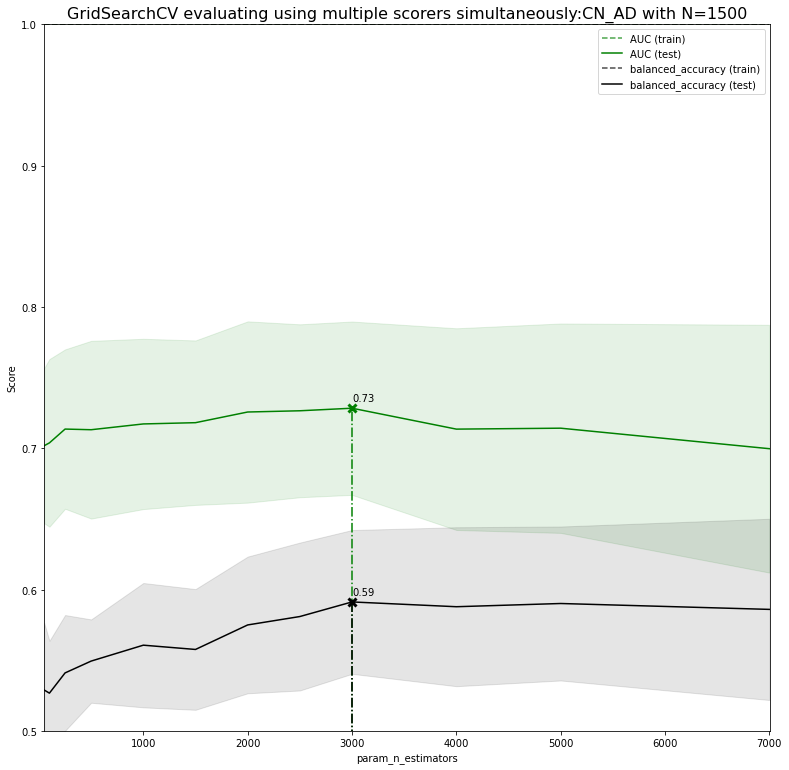

In [96]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)

X, y = df, y
# define model
model = GradientBoostingClassifier(random_state=1)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search space
space = dict()
space['n_estimators'] = [50,100,250,500,1000,1500,2000,2500,3000,4000,5000,7000]

scoring = {'AUC': 'roc_auc', 'balanced_accuracy':'balanced_accuracy'}
# define search
search = GridSearchCV(model, space,n_jobs=-1, cv=cv,scoring=scoring, refit='balanced_accuracy', return_train_score=True)
# execute search
result = search.fit(X, y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)


##PLOT##
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py

# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

results = search.cv_results_

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

print(__doc__)


plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously:"+groups+' with N='+str(N),
          fontsize=16)

plt.xlabel("param_n_estimators")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(min(space['n_estimators']), max(space['n_estimators'])+2)
ax.set_ylim(0.50, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

In [97]:
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)

def classifier(name,n_estimators=100):
    if name == 'RandomForestClassifier':
        return RandomForestClassifier(n_estimators=n_estimators,criterion='gini',class_weight='balanced')
    
    if name == 'GradientBoosting':
        return GradientBoostingClassifier(n_estimators=n_estimators,random_state=1)
    
    else:
        raise NotImplementedError("This classifier is not implemented yet. Please choose from [RandomForest, GradientBoosting]")
        

In [99]:
import numpy as np
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score, balanced_accuracy_score
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
acc = []
f1 = []
auc = []
imp = []
for train, test in cv.split(X, y):
    X_train = X.iloc[train]
    y_train = y[train]
    
    X_test = X.iloc[test]
    y_test = y[test]
    
    n_estimators = 3000 #Best from Hyperparameter search
    model = classifier('GradientBoosting', n_estimators)
    probas_ = model.fit(X_train, y_train).predict_proba(X_test)
    y_pred = model.predict(X_test)
    acc.append(balanced_accuracy_score(y_test, y_pred))
    f1.append(f1_score(y_test, y_pred, average='macro'))
    auc.append(roc_auc_score(y_test, probas_[:, 1]))	    	
    imp.append(model.feature_importances_)
print(sum(acc)/len(acc))
print(sum(auc)/len(auc))

0.5912393162393161
0.7271723646723647


In [100]:
imp = np.array(imp)
imp = imp.mean(axis=0)
imp.shape

(1503,)

In [101]:
imp_df = pd.DataFrame(columns=['features','importance'])
imp_df['features'] = list(X.columns)
imp_df['importance'] = imp
imp_df

,features,importance
0,AGE,4.749952e-02
1,PTGENDER,1.695968e-08
2,PTEDUCAT,1.904560e-05
3,11761978_at_ARHGEF12,1.001344e-03
4,11754382_a_at_SMIM5,1.937917e-05
...,...,...
1498,11720395_a_at_NBN,2.137767e-06
1499,11733071_a_at_SLC3A2,1.045084e-06
1500,11720585_a_at_SMCHD1,5.448871e-04
1501,11742314_x_at_SLC35G6,1.003729e-03


In [102]:
imp_df_sorted = imp_df.sort_values(by=['importance'],ascending=False)
imp_df_sorted

,features,importance
0,AGE,4.749952e-02
44,11716563_s_at_AIMP2,3.917013e-02
248,11739849_x_at_UPK3BL || POLR2J2 || POLR2J3,2.714297e-02
834,11749369_a_at_VAPB,2.592623e-02
31,11762503_at_11762535_at,2.227682e-02
...,...,...
1181,11741712_a_at_IGF2BP2,2.973493e-14
1064,11742220_x_at_CD46,5.586018e-16
481,11734952_a_at_MBNL3,5.134335e-19
867,11757537_x_at_RAD23A,1.141792e-19


In [104]:
imp_df_sorted.to_csv('ranked_probes_'+groups+'_with_N='+str(N)+'.csv')